In [1]:
import numpy as np
from scipy import constants as const
from scipy import sparse as sparse
from scipy.sparse.linalg import eigsh
from matplotlib import pyplot as plt
 
N = 500
l = 0
r = np.linspace(2e-9, 0.0, N, endpoint=False)
r=r*1.88973e10

In [2]:
potential = 1/r
potential_term = sparse.diags((potential))

angular = l * (l + 1) / r**2
angular_term = sparse.diags((angular))
h = r[1] - r[0]
main_diag = -2.0 / h**2 * np.ones(N)     
off_diag  =  1.0 / h**2 * np.ones(N - 1)
laplace_term = sparse.diags([main_diag, off_diag, off_diag], (0, -1, 1))

###################

##############
hamiltonian = -0.5* (laplace_term - angular_term) - potential_term 


In [3]:
""" solve eigenproblem """
number_of_eigenvalues = 20
eigenvalues, eigenvectors = eigsh(hamiltonian, k=number_of_eigenvalues, which='SM')
 
""" sort eigenvalue and eigenvectors """
psi = np.array([x for _, x in sorted(zip(eigenvalues, eigenvectors.T), key=lambda pair: pair[0])])
eigenvalues = 2*np.sort(eigenvalues)
 
""" compute probability density for each eigenvector """
densities = [np.absolute(psi[i, :])**2 for i in range(len(eigenvalues))]


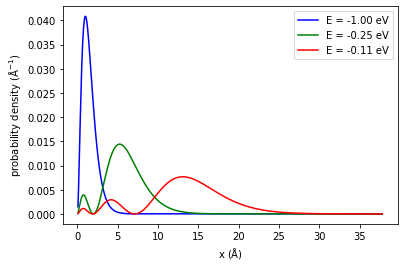

In [4]:
def plot(r, densities, eigenvalues):
    plt.xlabel('x ($\\mathrm{\AA}$)')
    plt.ylabel('probability density ($\\mathrm{\AA}^{-1}$)')

     
    energies = ['E = {: >5.2f} eV'.format(eigenvalues[i].real) for i in range(3)]
    plt.plot(r , densities[0], color='blue',  label=energies[0])
    plt.plot(r , densities[1], color='green', label=energies[1])
    plt.plot(r , densities[2], color='red',   label=energies[2])
     
    plt.legend()
    plt.show()
    return
 
""" plot results """

plot(r, densities, eigenvalues)

In [5]:
eigenvalues

array([-0.99857563, -0.24991079, -0.11108601, -0.06015785, -0.01621813,
        0.04456502,  0.12217395,  0.2155655 ,  0.32415912,  0.44759484,
        0.58562872,  0.73808511,  0.90483196,  1.08576664,  1.28080731,
        1.48988711,  1.71295033,  1.94994959,  2.20084387,  2.465597  ])

In [6]:
#######Sanity Check wavefucntions are normalized###########
J=0
for i in range(500):
    J+=(psi[0,i]**2)
print(J)

0.9999999999999941


In [7]:
#number of basis functions
n=1
#Calculating overlap matrix
S=np.zeros([n,n])
for i in range(n):
    for j in range(n):
            for k in range(500):
                S[i,j]+=psi[i,k]*psi[j,k]
        
print(S)

[[1.]]


In [8]:
T=np.zeros([n,n])
for i in range(n):
    for j in range(n):
            for k in range(500):
                if j==1:
                    l=1
                    T[i,j]+=psi[i,k]*psi[j,k]+ l*(l+1)*psi[i,k]*psi[j,k]/(r[k]**2)
                elif j==0:
                    l=0
                    T[i,j]+=psi[i,k]*psi[j,k]+ l*(l+1)*psi[i,k]*psi[j,k]/(r[k]**2)
        
T=T*0.5
print(T)

[[0.5]]


In [9]:
Vn=np.zeros([n,n])
for i in range(n):
    for j in range(n):
            for k in range(500):
                Vn[i,j]+=psi[i,k]*psi[j,k]/(r[k])
Z=2 #Helium        
Vn=-Z*Vn
print(Vn)

[[-1.99431064]]


In [10]:
from scipy.linalg import eigh
F=T+Vn
energy,eigenvec=eigh(F)
print("energy",energy)
print("mol orb",eigenvec)

energy [-1.49431064]
mol orb [[1.]]


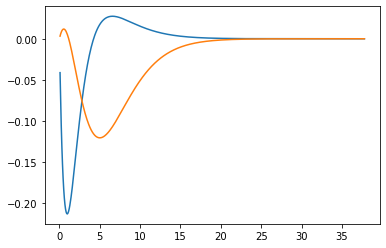

In [11]:
bond_mo_orb=-0.96591131*psi[0,:] + 0.29528468*psi[1,:]
anti_bond_mo_orb=-0.25887323*psi[0,:]  -0.96591131*psi[1,:]
plt.plot(r,bond_mo_orb)
plt.plot(r,anti_bond_mo_orb)

In [12]:
print(F)

[[-1.49431064]]


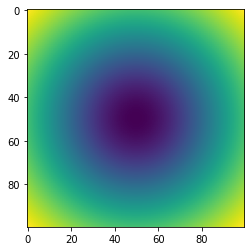

In [13]:
N=100
def get_potential(x,y,z):
    r = np.sqrt(x**2 + y**2 +z**2)
    r = np.where(r < 10**(-5), 10**(-5), r)
    V = 1/ r
    return -V
X,Y,Z= np.meshgrid(np.linspace(-10,10,N, dtype=float),
                   np.linspace(-10,10,N, dtype=float),
                  np.linspace(-10,10,N, dtype=float))
V= get_potential(X,Y,Z)
plt.imshow(V[:,0,:])

In [19]:
# diag = np.ones([N])
# diags = np.array([diag, -2*diag, diag])
# D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
# T = -1/2 * sparse.kronsum(D,D,D)
# U = sparse.diags(V.reshape(N**3), (0))
# H = T+U
from scipy.sparse import diags,kron
from scipy.sparse.linalg import eigs
I=np.eye(N)
T_=diags([-2.,1.,1.],[0,-1,1], shape=(N,N))*(-0.5)
T=kron(T_,kron(I,I))+kron(I,kron(I,T_))+kron(I,kron(T_,I))
U = sparse.diags(V.reshape(N**3), (0))
H = T+U

In [ ]:
eigenenergy, eigenstates=eigs(H,k=10,which='LM',sigma=0)

In [174]:
nn=10
eigenvalues, eigenvectors = eigsh(H, k=nn, which='SM')
def get_e(n):
    return eigenvectors.T[n].reshape((N,N))

KeyboardInterrupt: 

In [ ]:
plt.bar(np.arange(0,10,1),eigenvalues[0:10])

In [ ]:
N = 150
X1, X2 = np.meshgrid(np.linspace(0,1,N, dtype=float),
                   np.linspace(0,1,N, dtype=float))

In [ ]:
def get_potential(x,y):
    return 0*x
#def get_potential(x, y):
#    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V = get_potential(X1,X2)

In [ ]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T+U

In [ ]:
nn=10
eigenvalues, eigenvectors = eigsh(H, k=nn, which='SM')
def get_e(n):
    return eigenvectors.T[n].reshape((N,N))

In [ ]:
#for i in range(1):
nn
for i in range(nn):
    a = (get_e(i) - get_e(i).swapaxes(0,1))/np.sqrt(2)
    for k in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[k,j]*a[k,j]<10**(-15):
                a[k,j]=0
    plt.figure(figsize=(9,9))
    plt.contourf(X1, X2, a**2, 20)

In [ ]:
plt.bar(np.arange(0, nn, 1), eigenvalues[0:nn])

In [ ]:
N = 150
X1, X2 = np.meshgrid(np.linspace(0,1,N, dtype=float),
                   np.linspace(0,1,N, dtype=float))
def get_potential(x,y):
    r = np.abs(x - y)
    r = np.where(r < 10**(-5), 10**(-5), r)
    V = 1/ r
    print(r)
    return V,r
#def get_potential(x, y):
#    return np.exp(-(x-0.3)**2/(2*0.1**2))*np.exp(-(y-0.3)**2/(2*0.1**2))
V,rr = get_potential(X1,X2)
plt.contourf(X1, X2, V, 20)

In [ ]:
#plt.imshow(rr)
np.min(rr)


In [ ]:
diag = np.ones([N])
diags = np.array([diag, -2*diag, diag])
D = sparse.spdiags(diags, np.array([-1,0,1]), N, N)
T = -1/2 * sparse.kronsum(D,D)
U = sparse.diags(V.reshape(N**2), (0))
H = T+U

In [ ]:
nn=10
eigenvalues, eigenvectors = eigsh(H, k=nn, which='SM')
def get_e(n):
    return eigenvectors.T[n].reshape((N,N))
plt.contourf(X1, X2, get_e(0)**2, 20)

In [ ]:
#for i in range(1):
nn
for i in range(nn):
    a = (get_e(i) - get_e(i).swapaxes(0,1))/np.sqrt(2)
    for k in range(a.shape[0]):
        for j in range(a.shape[1]):
            if a[k,j]*a[k,j]<10**(-15):
                a[k,j]=0
    plt.figure(figsize=(9,9))
    plt.contourf(X1, X2, a**2, 20)

In [ ]:
plt.bar(np.arange(0, nn, 1), eigenvalues[0:nn])
plt.ylim(1.1,1.5)

In [ ]:
!pip install notebook-as-pdf
